In [1]:
import os
import pandas as pd
import numpy as np
import sklearn
import h5py
import scanpy as sc
import anndata
import gc
import pickle
from einops import rearrange
import matplotlib.pyplot as plt

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# %pip install scanpy
# %pip install anndata
# %pip install lightgbm
# %pip install numpy scikit-learn

# Load data 

In [3]:
DATA_DIR = "/home/wuxinchao/data/project/kaggle_comp_scmo_data/data"
CELL_METADATA = os.path.join(DATA_DIR, "metadata.csv")
CITE_TRAIN_INPUTS = os.path.join(DATA_DIR, "train_cite_inputs.h5")
CITE_TRAIN_TARGETS = os.path.join(DATA_DIR, "train_cite_targets.h5")
CITE_TEST_INPUTS = os.path.join(DATA_DIR, "test_cite_inputs.h5")

MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR, "train_multi_inputs.h5")
MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR, "train_multi_targets.h5")
MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR, "test_multi_inputs.h5")

SUBMISSION = os.path.join(DATA_DIR, "sample_submission.csv")
EVALUATION_IDS = os.path.join(DATA_DIR, "evaluation_ids.csv")

In [8]:
df_cell = pd.read_csv(CELL_METADATA)
df_cell_cite = df_cell[df_cell.technology=="citeseq"]
df_cell_multi = df_cell[df_cell.technology=="multiome"]
df_cell_cite.shape, df_cell_multi.shape

((119651, 5), (161877, 5))

In [10]:
# check dsb and centered log-ration for normalization of protein data

df_cell_cite.columns

Index(['cell_id', 'day', 'donor', 'cell_type', 'technology'], dtype='object')

# Preprocess for CITEseq

In [13]:
%%time

col_start = 10000

class PreprocessCiteseq(BaseEstimator, TransformerMixin):
    columns_to_use = 13000

    @staticmethod
    def take_column_subset(X):
        return X[:, -(PreprocessCiteseq.columns_to_use + col_start):-col_start]
    
    def transform(self, X):
        print(X.shape)
        X = X[:, ~self.all_zero_columns]
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X)
        print(X.shape)
        gc.collect()

        X = self.pca.transform(X)
        print(X.shape)
        return X
    
    def fit_transform(self, X):
        gc.collect()
        print(X.shape)
        self.all_zero_columns = (X == 0).all(axis=0)
        X = X[:, ~self.all_zero_columns]
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X)
        print(X.shape)
        gc.collect()

        self.pca = PCA(n_components=240, copy=False, random_state=1)
        X = self.pca.fit_transform(X)
        print(X.shape)
        return X

preprocesser = PreprocessCiteseq()
cite_train_x = None
cite_train_x = preprocesser.fit_transform(pd.read_hdf(CITE_TRAIN_INPUTS).values)

cite_train_y = pd.read_hdf(CITE_TRAIN_TARGETS).values
print(cite_train_x.shape, cite_train_y.shape)

(70988, 22050)
(70988, 21601)
(70988, 11601)
(70988, 240)
(70988, 240) (70988, 140)
CPU times: user 22min 37s, sys: 8min 14s, total: 30min 52s
Wall time: 1min 4s


In [5]:
# check the distribution of the protein data
# get the cell id and protein id of the citeseq data
cite_train_y = pd.read_hdf(CITE_TRAIN_TARGETS)
print(cite_train_y.columns) # the protein id
print(cite_train_y.index) # the cell id

Index(['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40',
       'CD154', 'CD52',
       ...
       'CD94', 'CD162', 'CD85j', 'CD23', 'CD328', 'HLA-E', 'CD82', 'CD101',
       'CD88', 'CD224'],
      dtype='object', name='gene_id', length=140)
Index(['45006fe3e4c8', 'd02759a80ba2', 'c016c6b0efa5', 'ba7f733a4f75',
       'fbcf2443ffb2', 'd80d84ca8e89', '1ac2049b4c98', '33fb0c29e2e4',
       'b329261bd0ee', '703762287e88',
       ...
       'f901120ab887', 'e3780c598532', '663da056425f', '10b466d6898b',
       '4d22a430b2b8', '650ee456f0f3', 'cc506e7707f5', 'a91f1b55a520',
       '3a9882c98205', 'c91b6b2ccd3d'],
      dtype='object', name='cell_id', length=70988)


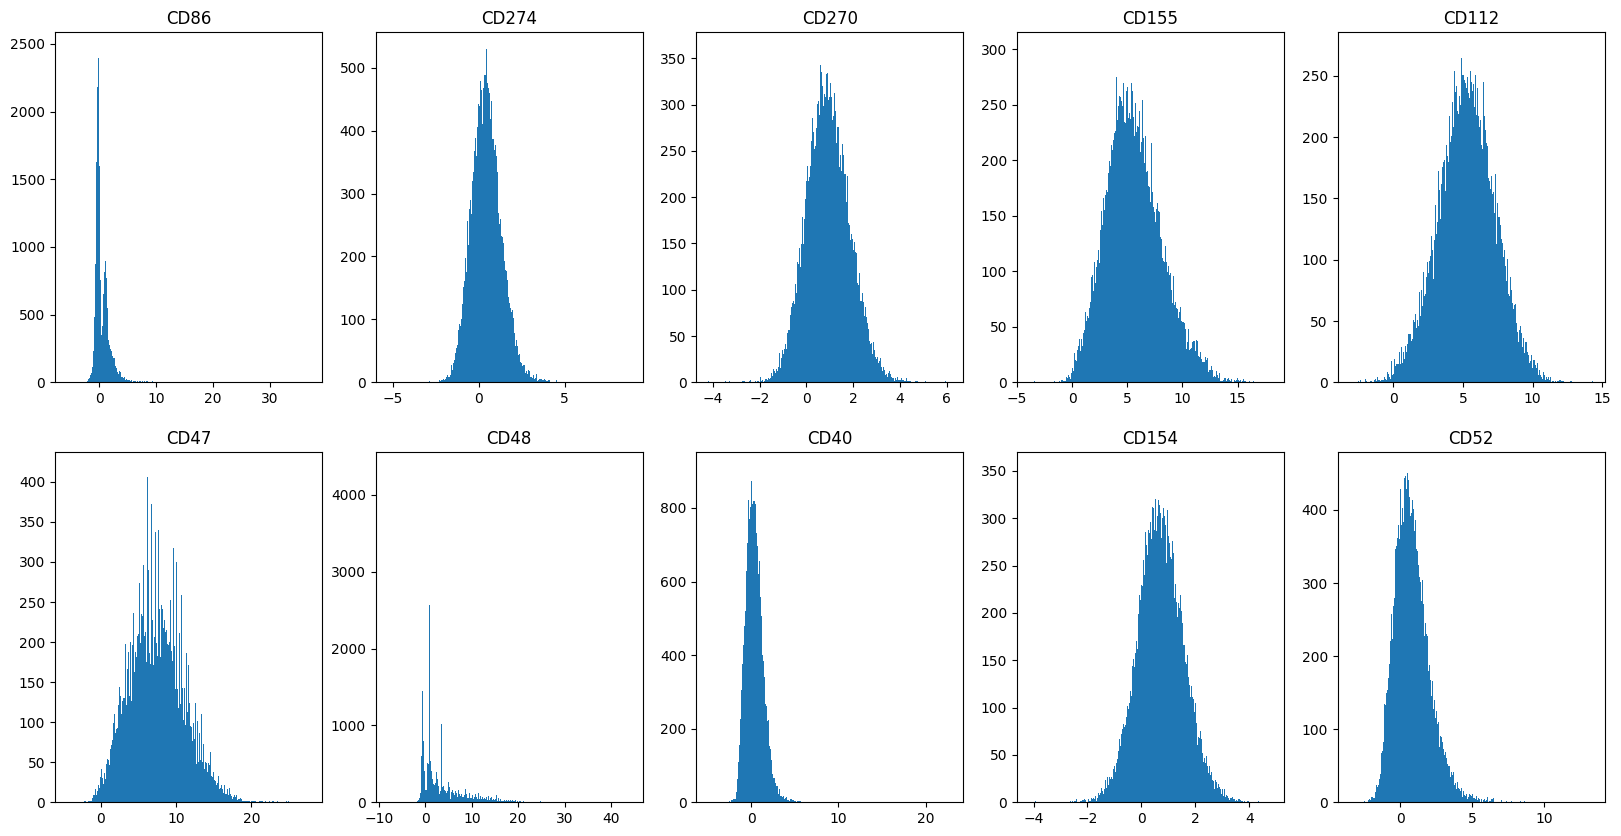

In [6]:
# show the distribution of the protein data of CD86
# CD86_expression = cite_train_y['CD86']
# plt.hist(CD86_expression, bins=1000)
# plt.show()

# show the distribution of the first 10 protein data
# the plots are subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    axs[i//5, i%5].hist(cite_train_y[cite_train_y.columns[i]], bins=1000)
    axs[i//5, i%5].set_title(cite_train_y.columns[i])
plt.show()

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


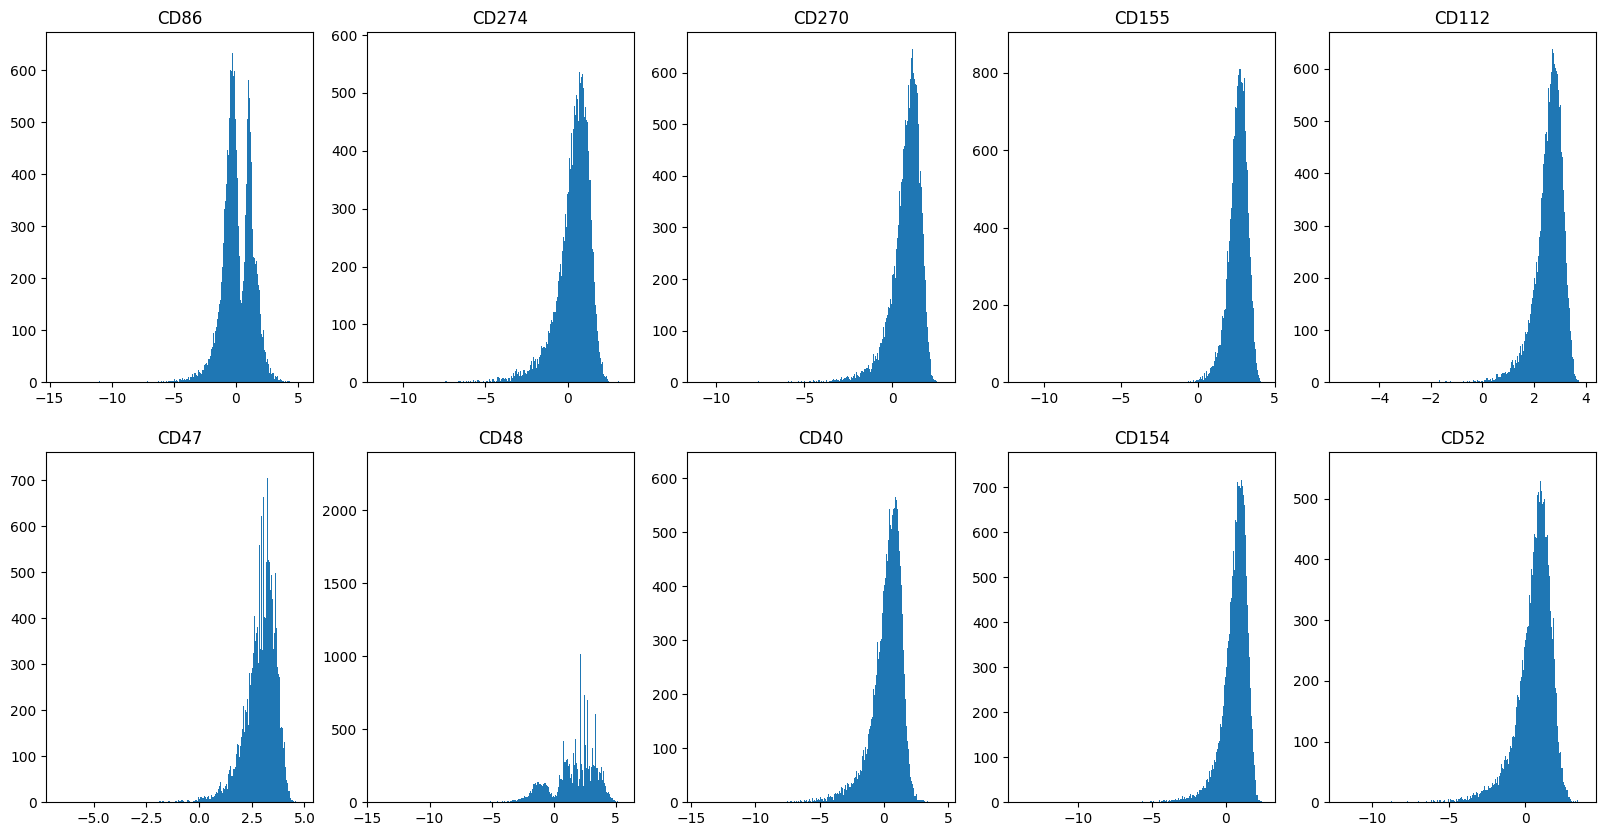

In [7]:
# show the centered log-ratio normalized protein data
# the plots are subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    axs[i//5, i%5].hist(np.log2(cite_train_y[cite_train_y.columns[i]] + 1), bins=1000)
    axs[i//5, i%5].set_title(cite_train_y.columns[i])
plt.show()

# Modeling & Prediction

In [ ]:
params = {
    'learning_rate': 0.5,
    'metric': 'mae',
    'seed': 42,
    'reg_alpha': 0.0014,
    'reg_lambda': 0.2,
    'colsample_bytree': 0.8,
    'subsample': 0.5,
    'max_depth': 12,
    'num_leaves': 722,
    'min_child_samples': 85,
}

model = MultiOutputRegressor(lgb.LGBMRegressor(**params, n_estimators=1000))
print("fitting")
model.fit(cite_train_x, cite_train_y)
print("fit proces done")

y_va_pred = model.predict(cite_train_x)
mse = mean_squared_error(cite_train_y, y_va_pred)
print(mse)
del cite_train_x, cite_train_y
gc.collect()

In [ ]:
cite_test_x = preprocesser.transform(pd.read_hdf(CITE_TEST_INPUTS).values)
test_pred = model.predict(cite_test_x)
del cite_test_x
test_pred.shape

# Gene expression embedding

In [23]:
# %pip install torch
%pip install einops

     |████████████████████████████████| 41 kB 285 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torch.nn as nn
import torch.functional as F
from einops import rearrange
import numpy as np

In [17]:
x = torch.randn(5,5,5,5)
y = torch.randn(5,5,5,5)

In [19]:
# torch.einsum('b c h w -> b*w c h',x)
torch.einsum('b k h w, b k h w -> b h w', x, y).shape

torch.Size([5, 5, 5])

In [21]:
a = torch.randn(10,20,30) # b -> 10, i -> 20, k -> 30
c = torch.randn(10,50,30) # b -> 10, j -> 50, k -> 30
y1 = torch.einsum('b i k, b j k -> b i j', a , c) # shape [10, 20, 50]
print(y1.shape)

torch.Size([10, 20, 50])


In [27]:
x = torch.randn(10, 100, 1000) # batch, tokens, dim
dim = 1000 ## simulated # of gene
to_qkv = nn.Linear(dim, dim*3, bias=False) ## init qkv matrix
qkv = to_qkv(x) ## x is the gene expression embedding vector
q, k, v = tuple(rearrange(qkv, 'b t (d k) -> k b t d', k=3))
print(q.shape, k.shape, v.shape)

torch.Size([10, 100, 1000]) torch.Size([10, 100, 1000]) torch.Size([10, 100, 1000])


In [8]:
# The input dimension of gene expression is (batch, expression, num_hid) (64, 2000, 64)
# The output dimension of multi-head attention is (batch, expression, num_hid)
class multiHeadAtten(nn.Module):
    def __init__(self, num_hid, num_heads=8):
        super().__init__()
        self.num_hid = num_hid
        self.num_heads = num_heads
        self.scale = 1 / (num_hid ** 0.5)
        _dim = num_hid * self.num_heads
        self.to_qkv = nn.Linear(num_hid, _dim * 3, bias=False)
        self.W_o = nn.Linear(_dim, num_hid)
    
    def forward(self, x, mask=None):
        assert x.dim() == 3, 'Input must be (batch size, expression, num_hid)'
        qkv = self.to_qkv(x) # (batch, expression, num_hid * 3)
        q, k, v = tuple(rearrange(qkv, 'b t (d k) -> k b h t d', k=3, h=self.num_heads)) # (batch, num_head ,expression, num_hid)
        scaled_dot_product = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.scale # (batch, num_head, expression, expression)
        if mask is not None:
            assert mask.shape == scaled_dot_product.shape[1:]
            scaled_dot_product = scaled_dot_product.masked_fill(mask, -1e9)
        attn = torch.softmax(scaled_dot_product, dim=-1) # (batch, num_head, expression, expression)
        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v) # (batch, num_head, expression, num_hid)
        out = rearrange(out, 'b h t d -> b t (h d)') # (batch, expression, num_hid * num_head)
        return self.W_o(out) # (batch, expression, num_hid)

class TransformerBlock(nn.Module):
    def __init__(self, num_hid, num_heads, dim_linear=1024, dropout=0.1):
        super().__init__()
        self.num_hid = num_hid
        self.num_heads = num_heads
        self.attn = multiHeadAtten(num_hid, num_heads)
        self.drop = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(num_hid)
        self.norm2 = nn.LayerNorm(num_hid)

        self.linear = nn.Sequential(
            nn.Linear(num_hid, dim_linear),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_linear, num_hid),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        y = self.norm1(self.drop(self.attn(x)) + x)
        return self.norm2(self.linear(y) + y)

class TransformerEncoder(nn.Module):
    def __init__(self, num_hid, num_heads, num_blocks):
        super().__init__()
        self.num_hid = num_hid
        self.num_heads = num_heads
        self.blocks = [TransformerBlock(num_hid, num_heads) for _ in range(num_blocks)]
        self.layers = nn.ModuleList(self.blocks)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [9]:
model = TransformerEncoder(64, 8, 6)
print(model)

TransformerEncoder(
  (layers): ModuleList(
    (0): TransformerBlock(
      (attn): multiHeadAtten(
        (to_qkv): Linear(in_features=64, out_features=1536, bias=False)
        (W_o): Linear(in_features=512, out_features=64, bias=True)
      )
      (drop): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=64, out_features=1024, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=1024, out_features=64, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerBlock(
      (attn): multiHeadAtten(
        (to_qkv): Linear(in_features=64, out_features=1536, bias=False)
        (W_o): Linear(in_features=512, out_features=64, bias=True)
      )
      (drop): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm((64,), eps=1e-05, e

We have already construct CITE-seq training project, but how do we implement integration, which is a two-stream encoder that using both modality information. The input size of transcriptome is 70988 x 240. And the input size of proteome is 70988 x 140. Both of the modality could be interact in the cross attention blocks.

Now let's embedding the features size of transcriptome and proteome into 64, and then implement cross attention.

There are three ways to embed the features size of transcriptome and proteome into 64. The first way is to use the linear layer. The second way is to use the convolutional layer. The third way is to use the PCA or NMF to reduce the dimension of transcriptome and proteome. We will use the first way to implement the embedding. 

In [ ]:
class gene2vec_embedding(nn.Module):
    #(batch, input_dim, hid_dim, output_dim)
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.linearLayer1 = nn.Linear(input_dim, hid_dim)
        self.linearLayer2 = nn.Linear(hid_dim, output_dim)

    def forward(self, x): 
        # x is the gene expression profile, shape (batch, cell, expression)
        # each batch contains multiple cells, each cell contains multiple genes
        # the output of the model is the gene embedding vector
        x = self.linearLayer1(x)
        x = self.linearLayer2(x)
        return x

class protein2vec_embedding(nn.Module):
    # (batch, input_dim, hid_dim, output_dim)
    def __init__(self, input_dim, hid_dim, output_dim) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.linearLayer1 = nn.Linear(input_dim, hid_dim)
        self.linearLayer2 = nn.Linear(hid_dim, output_dim)

    def forward(self, x):
        # x is the protein expression profile, shape (batch, cell, expression)
        # each batch contains multiple cells, each cell contains multiple proteins
        # the output of the model is the protein embedding vector
        x = self.linearLayer1(x)
        x = self.linearLayer2(x)
        return x

The cross attention block is a two-stream encoder that using both modality information. The input size of transcriptome is (batch size, cell number, feature size), and the input size of proteome is (batch size, cell number, feature size). Both of the modality could be interact in the cross attention blocks.

The loss function has two parts. The 1st part is to calculate the consistency loss between the embedding of transcriptome and proteome. The 2nd part is to calculate the reconstruction loss between the embedding of transcriptome and proteome.

The consistance loss is the loss function that using to calculate the distance between the embedding of transcriptome and proteome. The distance is calculated by the cosine similarity. 

In [ ]:
class two_stream_attention(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim, num_heads, num_blocks):
        super().__init__()
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.num_heads = num_heads
        self.num_blocks = num_blocks
        self.gene2vec = gene2vec_embedding(input_dim, hid_dim, output_dim)
        self.protein2vec = protein2vec_embedding(input_dim, hid_dim, output_dim)
        self.transformer = TransformerEncoder(output_dim, num_heads, num_blocks)
    
    def forward(self, gene, protein):
        gene = self.gene2vec(gene)
        protein = self.protein2vec(protein)
        gene = self.transformer(gene)
        protein = self.transformer(protein)
        return gene, protein

In [ ]:
class cross_attention(nn.Module):
    # cross attention between gene and protein
    # the input dimension of gene expression is decided by the batch_size, num_cell, num_gene_features
    # the input dimension of protein expression is decided by the batch_size, num_cell, num_protein_features
    # there are two inputs, one is gene expression, the other is protein expression
    # each of the input is an embedding vector, and each vector will be transformed into Q, K, V
    # the cross attention mechanism is used to calculate the similarity between gene and protein
    def __init__(self, num_hid, num_heads, dim_linear=64, dropout=0.1, _dim=None):
        super().__init__()
        self.num_hid = num_hid
        self.num_heads = num_heads
        _dim = int(num_hid / num_heads) if _dim is None else _dim
        

def reconstruction_loss(x, y):
    return torch.mean(torch.abs(x - y))

In [ ]:
# For the RNA and protein expression data
# show the histogram of the protein expression for one protein

plt.hist()